# Theory
## Loss Functions
Decision Tree use loss functions that evaluate the split based on the purity of the resulting nodes.

We have 3 choices for loss functions:

1. Gini Impurity Index:

Gini Impurity is measure of variance across the different classes

$ G(Node_{i}) = \sum \limits_{i=1}^{N} {p_{i}} (1-p_{i}) $


2. Entropy : 

Similar to Gini Impurity, Entropy is a measure of chaos within the node. 

$ E(Node_{i}) = -\sum \limits_{i=1}^{N} {p_{i}}log_{2}(p_{i}) $
3. Misclassification Error

$ M(N_{i}) = 1 - max_{i} p_{i} $

where $p_{i} = N_{i}/N $, is the proportion of number of observations at leaf i ($N_{i}$) to total observations (N)

## Data Transformations 



Decision trees are prone to orientation of the training data and prefer orthogonal decision boundaries. Training sets which are lineary separable generalize better than the ones which are not.
For example, in the image below [3] we can see a linearly separable dataset on the left, which can easliy be split up using a decision tree, while on the right side we have the same dataset after 45 degree rotation, the decision boundary becomes complex. 
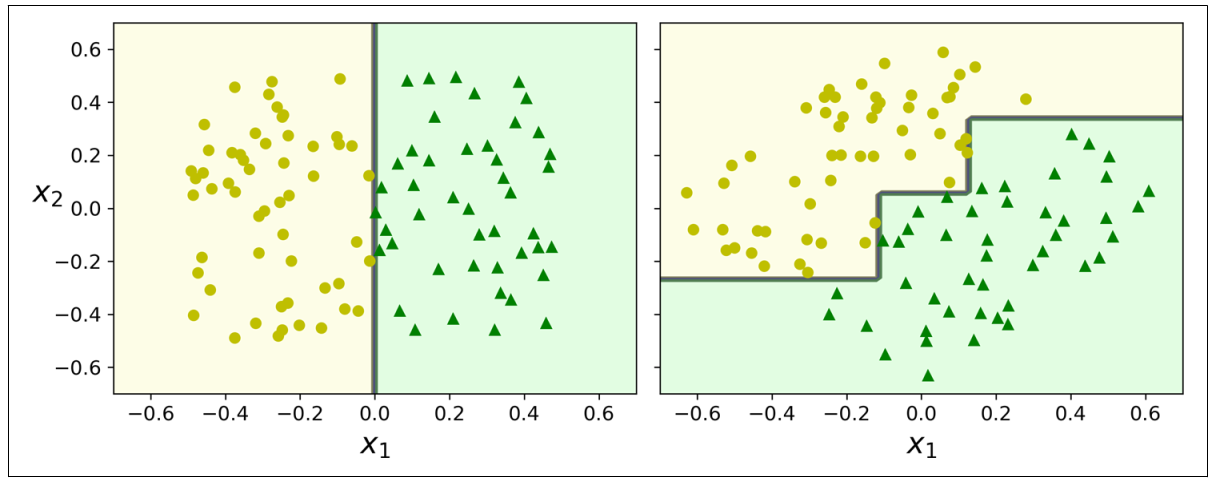

Best way to limit this problem is to use <b>Principal Component Analysis (PCA)</b>, which involves projection of original dataset into a hyperplane comprising of orthogonal principal components while preserves maximum amount of variance of the original features.

# Implementation Tasks

## Preparing Dataset and Extracting Features

I have used yahoo finance to extract daily OHLCV data for Bitocin/USD ticker. I have then constructed features based on the table provided in the question set.

The features considered below are:

1. Today's Open - Yesterday's Close (OmC)
1. Yesterday's High - Yesterday's Low (HmL)
1. Returns (1 Day, 5 Day and 10 Day Lags)
1. Momentum ( 3 Day, 5 Day and 10 Day Lags)
1. Simple Moving Averages (SMA, 5 Day, 10 Day and 30 Day Lags)

The dependent variable is the 1 Day Move Direction which is constructed based on 1 Day returns exceeding the threshold. I have considered the median returns to be the threshold for this analyis to make the dataset balanced.



$Y(Move Direction) = \begin{cases}
    1 ,& \text{if } Return\geq Median(Returns)\\
    0,              & \text{otherwise}
\end{cases} $




In [612]:
# Import required libraries
import pandas as pd
import numpy as np
import os as os
# Import yahoo finance libraries
import yfinance as yf

# Data Processing
from sklearn.preprocessing import StandardScaler

# Visualizaiton
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
#TrainTest Splitting

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,classification_report

#Hyperparameter FineTuning 

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split, KFold,cross_val_score

#Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Ensembles
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor

# XGBoost Classifier
from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

#Performance Metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, roc_auc_score

import pyfolio as pf
#conda install graphviz

In [370]:
OHLCV = yf.download('BTC-USD', start='2016-11-01', end='2022-11-01', progress=False)
OHLCV

Open          High           Low         Close  \
Date                                                                 
2016-11-01    701.336975    736.452026    701.336975    729.793030   
2016-11-02    730.065979    740.828979    722.348999    740.828979   
2016-11-03    742.346008    745.773010    678.156006    688.700012   
2016-11-04    689.124023    706.929993    685.562988    703.234985   
2016-11-05    703.525024    707.510010    697.739014    703.418030   
...                  ...           ...           ...           ...   
2022-06-01  31792.554688  31957.285156  29501.587891  29799.080078   
2022-06-02  29794.890625  30604.734375  29652.705078  30467.488281   
2022-06-03  30467.806641  30633.035156  29375.689453  29704.390625   
2022-06-04  29706.138672  29930.564453  29500.005859  29832.914062   
2022-06-05  29836.292969  29869.662109  29582.658203  29666.560547   

               Adj Close       Volume  
Date                                   
2016-11-01    729.793030    130527000  
2016-11-02    740.828979     84865200  
2016-11-03    688.700012    172808000  
2016-11-04    703.234985     99907696  
2016-11-05    703.418030     53752300  
...                  ...          ...  
2022-06-01  29799.080078  41135817341  
2022-06-02  30467.488281  29083562061  
2022-06-03  29704.390625  26175547452  
2022-06-04  29832.914062  16588370958  
2022-06-05  29666.560547  16084995072  

[2043 rows x 6 columns]

In [318]:
def expo_MA(prices):
    ma = []
    alpha = 2/(len(prices) + 1)
    ma.append(prices[0])
    for i in range(1,len(prices)-1,1) :
        ma.append(ma[i-1] +alpha*(prices[i]-ma[i-1]))
    return ma 

In [392]:
Features = pd.DataFrame(data=None,index=OHLCV.index,columns=['OmC','HmL'])

#Today's Open Price - Yesterday's Close Price
Features.loc[1:,'OmC'] = [(OHLCV['Open'][i]-OHLCV['Close'][i-1]) for i in range(1,len(OHLCV),1)]

#Yesterday's High minus Low Price
Features.loc[1:,'HmL'] = [(OHLCV['High'][i-1]-OHLCV['Low'][i-1]) for i in range(1,len(OHLCV),1)]

#Computing T0 and lagged Daily Returns 
Features.loc[1:,'Returns'] = np.divide(np.array(OHLCV['Close'][1:]) -np.array(OHLCV['Close'][:-1]),np.array(OHLCV['Close'][:-1]))

Features.loc[1:,'ReturnLag1'] = [Features['Returns'][i] for i in range(0,len(Features)-1,1)]
Features.loc[5:,'ReturnLag5'] = [Features['Returns'][i] for i in range(0,len(Features)-5,1)]
Features.loc[10:,'ReturnLag10'] = [Features['Returns'][i] for i in range(0,len(Features)-10,1)]

#Computing 3 Day and 5 Day Momentums
Features.loc[4:,'Momentum3day'] = [(OHLCV['Close'][i]- OHLCV['Close'][i-3]) for i in range(3,len(OHLCV)-1,1)]
Features.loc[6:,'Momentum5day'] = [(OHLCV['Close'][i]- OHLCV['Close'][i-5]) for i in range(5,len(OHLCV)-1,1)]
Features.loc[11:,'Momentum10day'] = [(OHLCV['Close'][i]- OHLCV['Close'][i-10]) for i in range(10,len(OHLCV)-1,1)]


#Computing 5 Day and 10 Day Moving Average
Features.loc[6:,'SMA_5Day'] = [OHLCV['Close'].iloc[(i-5):i].mean(axis=0) for i in range(5,len(OHLCV)-1,1)]
Features.loc[11:,'SMA_10Day'] = [OHLCV['Close'].iloc[(i-10):i].mean(axis=0) for i in range(10,len(OHLCV)-1,1)]
Features.loc[31:,'SMA_30Day'] = [OHLCV['Close'].iloc[(i-30):i].mean(axis=0) for i in range(30,len(OHLCV)-1,1)]


Features.loc[1:len(Features),'EMA'] = expo_MA(OHLCV['Close'])


Features = Features.dropna()
Features

OmC      HmL   Returns  ReturnLag1  ReturnLag5  ReturnLag10  \
Date                                                                            
2016-12-02   0.770996   12.229  0.027974    0.014863   -0.004551     0.016367   
2016-12-03   0.304016   23.751 -0.008727    0.027974    0.005161    -0.008988   
2016-12-04   0.482971   13.392  0.003523   -0.008727   -0.000284    -0.005782   
2016-12-05  -0.478027    5.711 -0.019605    0.003523    0.013713     0.001837   
2016-12-06  0.0199585   21.755  0.007281   -0.019605    0.014863    -0.008450   
...               ...      ...       ...         ...         ...          ...   
2022-06-01   0.244141  963.709 -0.062695    0.002078   -0.021856     0.030290   
2022-06-02   -4.18945   2455.7  0.022430   -0.062695    0.006544    -0.040391   
2022-06-03   0.318359  952.029 -0.025046    0.022430    0.021900     0.019130   
2022-06-04    1.74805  1257.35  0.004327   -0.025046    0.077445    -0.003144   
2022-06-05    3.37891  430.559 -0.005576    0.004327    0.002078    -0.009984   

            Momentum3day  Momentum5day  Momentum10day      SMA_5Day  \
Date                                                                  
2016-12-02     20.960999     21.391968      17.526001    736.904993   
2016-12-03     42.339966     45.908997      26.596985    741.183386   
2016-12-04     25.464050     35.342041      26.561035    750.365186   
2016-12-05     17.098022     38.268005      33.583008    757.433594   
2016-12-06    -19.243958     13.009033      17.051025    765.087195   
...                  ...           ...            ...           ...   
2022-06-01   2977.410156   2525.085938    2360.083984  29576.409375   
2022-06-02    353.123047   1171.505859    -524.642578  30081.426563   
2022-06-03  -1258.902344   1652.587891    1368.578125  30315.727734   
2022-06-04  -2087.919922    258.433594      48.804688  30646.245312   
2022-06-05     33.833984  -1893.476562     270.552734  30697.932031   

               SMA_10Day     SMA_30Day           EMA  
Date                                                  
2016-12-02    740.165192    726.349101    729.722699  
2016-12-03    741.917792    727.248466    729.769882  
2016-12-04    744.577490    728.485632    729.810377  
2016-12-05    747.233594    731.234133    729.853490  
2016-12-06    750.591895    733.588700    729.881715  
...                  ...           ...           ...  
2022-06-01  29595.485352  31703.231706  21837.677287  
2022-06-02  29831.493750  31480.672266  21845.467310  
2022-06-03  29779.029492  31189.663997  21853.903729  
2022-06-04  29915.887305  30946.898503  21861.585223  
2022-06-05  29920.767773  30613.765820  21869.384958  

[2012 rows x 13 columns]

In [393]:
Features.describe()

Returns   ReturnLag1   ReturnLag5  ReturnLag10  Momentum3day  \
count  2012.000000  2012.000000  2012.000000  2012.000000   2012.000000   
mean      0.002681     0.002691     0.002728     0.002683     43.632050   
std       0.041216     0.041216     0.041185     0.041148   1609.876066   
min      -0.371695    -0.371695    -0.371695    -0.371695  -9453.617188   
25%      -0.015564    -0.015564    -0.015506    -0.015405   -269.318115   
50%       0.002363     0.002371     0.002371     0.002348     27.113525   
75%       0.021086     0.021086     0.020989     0.020927    364.432861   
max       0.252472     0.252472     0.252472     0.252472   8052.156250   

       Momentum5day  Momentum10day      SMA_5Day     SMA_10Day     SMA_30Day  \
count   2012.000000    2012.000000   2012.000000   2012.000000   2012.000000   
mean      73.514741     145.167286  17052.083358  17015.398531  16870.775568   
std     2097.166872    3021.680747  17525.459083  17506.878604  17429.211631   
min   -12878.093750  -21229.875000    736.904993    740.165192    726.349101   
25%     -332.960083    -530.345093   5786.839990   5787.689709   5584.244027   
50%       49.137238      85.011658   9050.847559   9080.223706   8974.786816   
75%      542.897827     817.670166  29781.046094  29879.152002  30697.048991   
max     9555.039062   14372.156250  65727.957812  64698.849609  62792.418880   

                EMA  
count   2012.000000  
mean    6368.344414  
std     5935.208759  
min      729.722699  
25%     2636.313079  
50%     4254.378336  
75%     7235.878182  
max    21869.384958

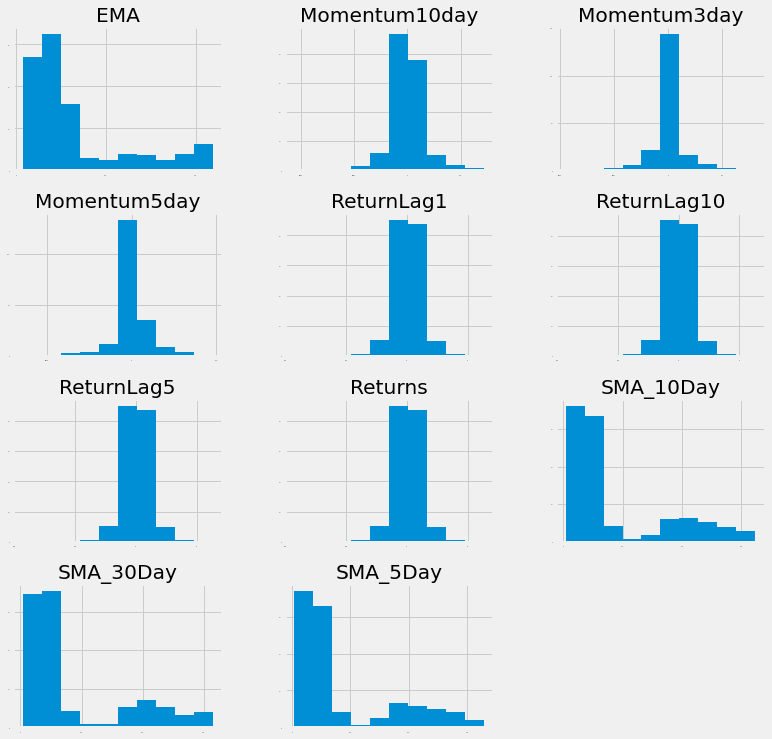

In [394]:
# histograms
Features.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

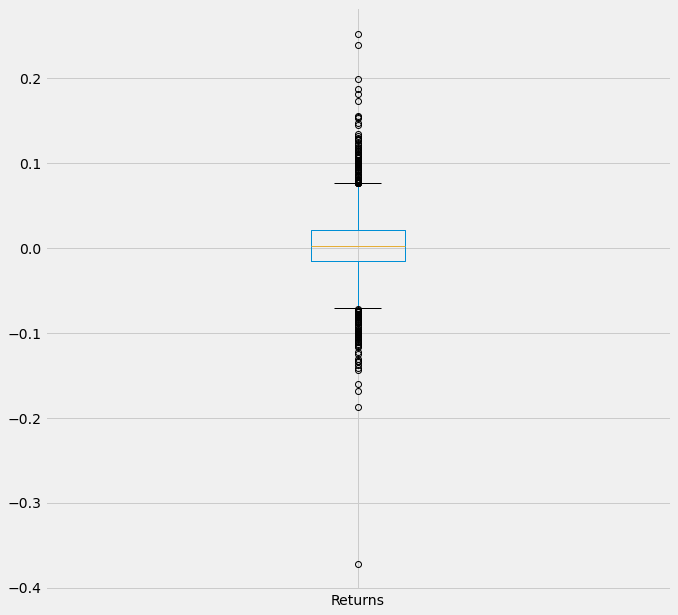

In [395]:
#Box and Whisker Plots
Features['Returns'].plot(kind='box', figsize=(10,10))
plt.show()

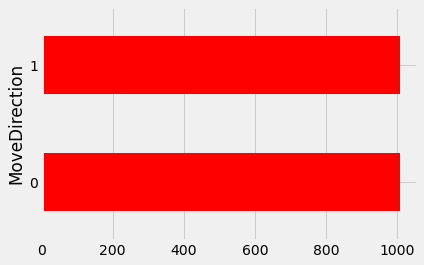

In [398]:
fig = plt.figure()
plot = Features.groupby(['MoveDirection']).size().plot(kind='barh', color='red')
plt.show()

In [683]:
Features.columns

Index(['OmC', 'HmL', 'Returns', 'ReturnLag1', 'ReturnLag5', 'ReturnLag10',
       'Momentum3day', 'Momentum5day', 'Momentum10day', 'SMA_5Day',
       'SMA_10Day', 'SMA_30Day', 'EMA', 'MoveDirection', 'Strategy'],
      dtype='object')

In [400]:
Features['MoveDirection'] = Features.Returns  > Features.Returns.median()
Features['MoveDirection'] = Features['MoveDirection'].astype(int)
#Features.MoveDirection.sum()/1247

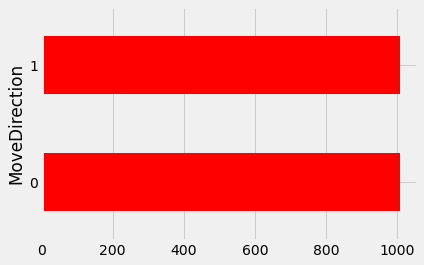

In [401]:
fig = plt.figure()
plot = Features.groupby(['MoveDirection']).size().plot(kind='barh', color='red')
plt.show()

In [471]:
X = Features[Features.columns.drop(['Returns','MoveDirection'])]
y = Features[['MoveDirection']]

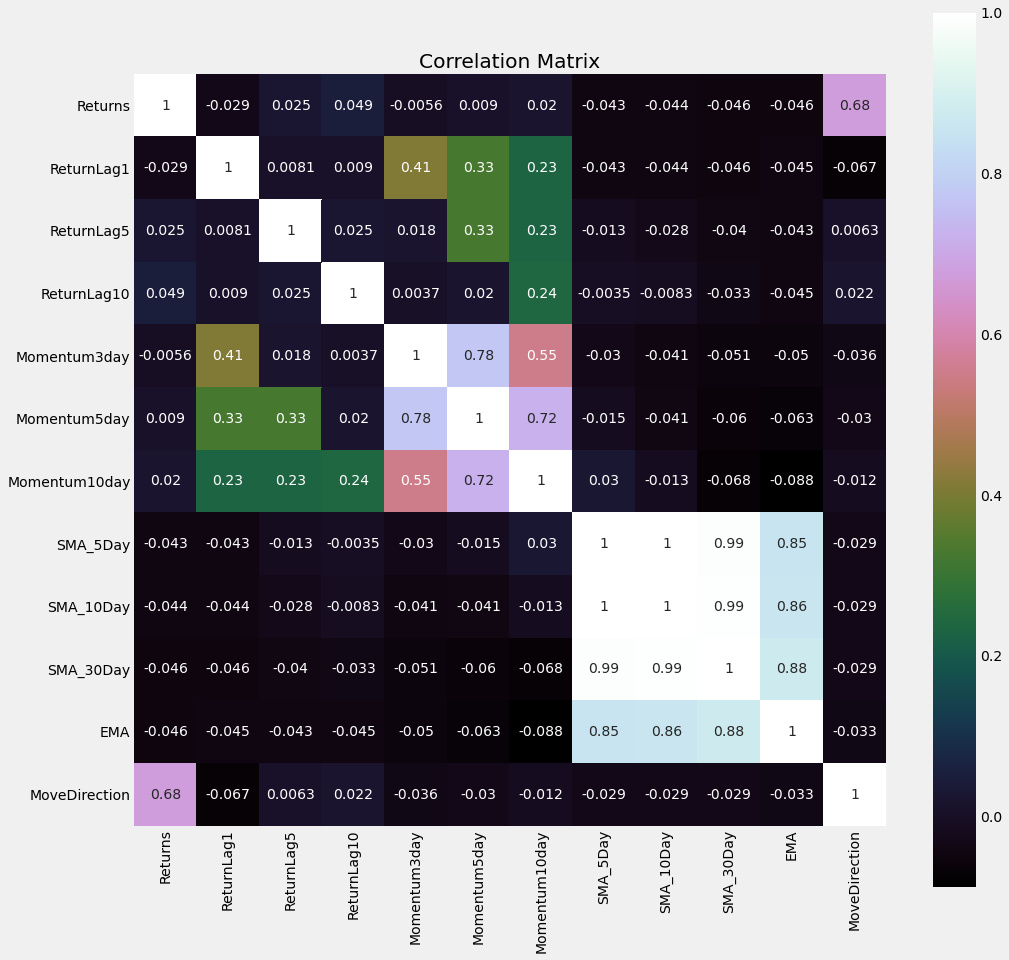

In [485]:
# correlation
correlation = Features.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [606]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=24)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 1609, 403


##  Decision Tree

### Unpruned Decision Tree

In [624]:
fulldecisionTree =  DecisionTreeClassifier(random_state =42)

fulldecisionTree.fit(X_train,y_train)

fulldecisionTree.score(X_test,y_test) 

fulldecisionTree.get_params()

#fig = plt.figure(figsize=(100,100))
#tree.plot_tree(decisionTree, feature_names=None,class_names=None,filled=True)

dot_data = tree.export_graphviz(fulldecisionTree, out_file=None, 
                                feature_names=list(X_test.columns),  
                                class_names=['Down','Up'],
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_graphivz")
Image(r"C:\Users\ASUS\Documents\CQF\Exam 3\decision_tree_graphivz.png")

In [626]:
depth_FullyGrownTree = fulldecisionTree.get_depth()

print("Maximum depth of tree is : "  + str(depth_FullyGrownTree))


Maximum depth of tree is : 30


In [490]:
print(classification_report(y_train,fulldecisionTree.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       502

    accuracy                           1.00      1006
   macro avg       1.00      1.00      1.00      1006
weighted avg       1.00      1.00      1.00      1006



In [627]:
print(classification_report(y_test,fulldecisionTree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       212
           1       0.48      0.50      0.49       191

    accuracy                           0.51       403
   macro avg       0.51      0.51      0.51       403
weighted avg       0.51      0.51      0.51       403



Area under ROC Curve : %f 0.5083843722216734


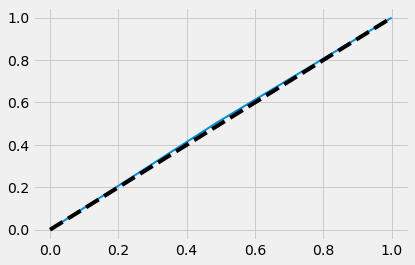

In [630]:
fpr,tpr, thresholds = roc_curve(y_test, fulldecisionTree.predict(X_test))

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

print('Area under ROC Curve : %f',roc_auc_score(y_test, fulldecisionTree.predict(X_test)))
plot_roc_curve(fpr, tpr)
plt.show()

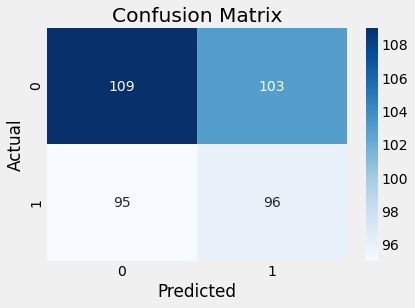

In [638]:
cm1= confusion_matrix(y_test,fulldecisionTree.predict(X_test))

temp1 = pd.DataFrame(cm1, index=['0', '1'], columns=['0', '1'])

sns.heatmap(temp1, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The fully grown tree perfectly fits (or Overfits) the training set. We will try resolve the problem using pruning in next section and also try to improve the prediction of negative moves by finding hyperparameters that <b> optimize precision and recall scores (f1 Score) </b>

### HyperParameter Tuning 

I have used Grid Search to perform hyper parameter tuning where we find optimal values of <b> maximum depth </b> (default value is none), <b> minimum samples required for a split </b> and <b> minimum samples required for a node to be a leaf </b>.

1.  Decision trees are prone to over fitting and makes the decision rules more complex. Pruning helps prevent overfitting and simplifies it by limiting the depth and setting minimum 

1.  Pruning should ensure that the subtree is optimal i.e it has the highest accuracy(or any other chosen metric) on the cross-validated training set.

1. The search for the optimal subtree should be computationally tractable.

Essentially, pruning recursively finds the node with the “weakest link.” The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first.

$ R_{\alpha}(T) = R (T) + \alpha \lvert{T}\rvert  $

where:
$R(T)$ — Total training error of leaf nodes <br>
$\alpha \lvert{T}\rvert$ — The number of leaf nodes <br>
$\alpha$ — complexity parameter(a whole number)

In [640]:
from sklearn.metrics import make_scorer,classification_report
decisionTree =  DecisionTreeClassifier(random_state = 42)


kfold = KFold(n_splits=3, random_state=42,shuffle=True)


max_depth_grid_search = GridSearchCV(estimator=decisionTree,scoring='f1',param_grid={"max_depth": range(1,depth_FullyGrownTree,1),
                                                                                         "min_samples_split": [2,10,20,40,80]
                                                                                        ,"min_samples_leaf":[1,10,20,40,80]},cv=kfold)

max_depth_grid_search.fit(X_train,y_train)
max_depth_grid_search.best_params_


{'max_depth': 6, 'min_samples_leaf': 80, 'min_samples_split': 2}

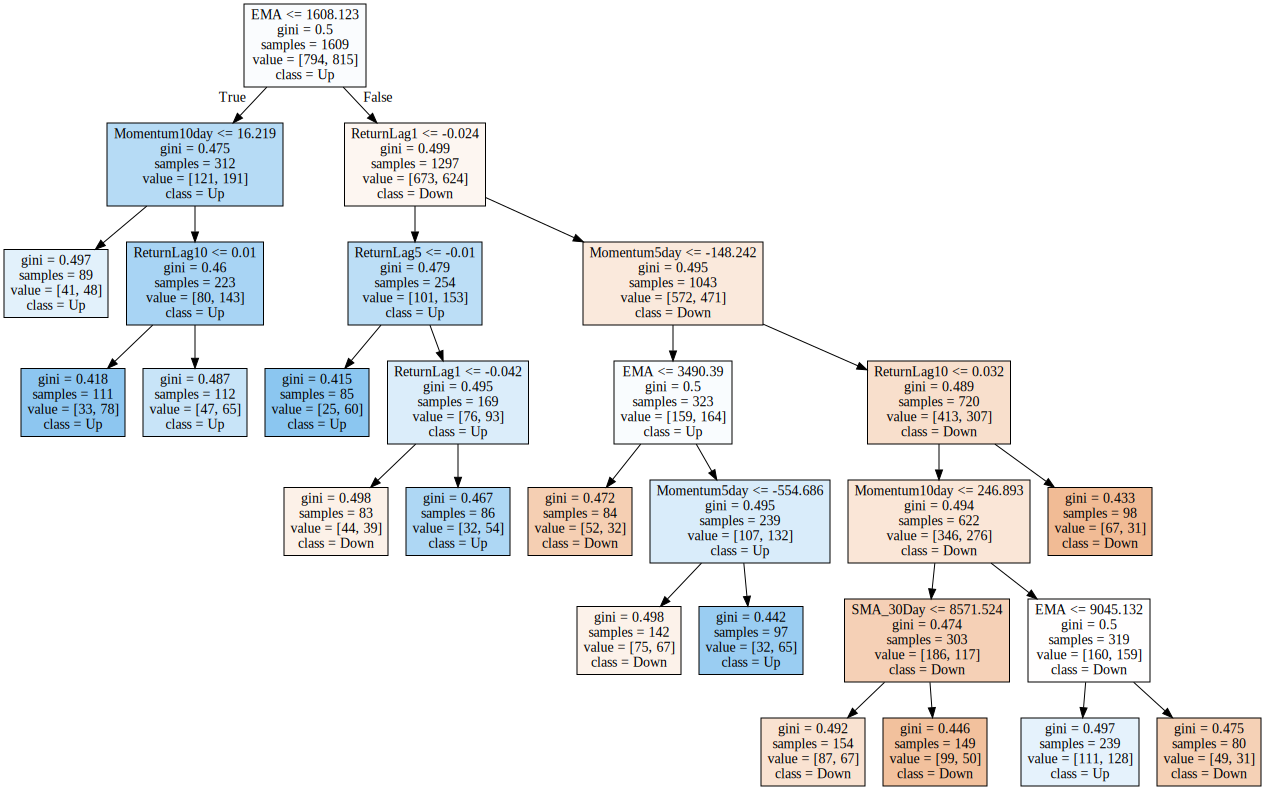

In [641]:
dot_data = tree.export_graphviz(max_depth_grid_search.best_estimator_, out_file=None, 
                                feature_names=list(X_test.columns),  
                                class_names=['Down','Up'],
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [642]:
optimalDepth = max_depth_grid_search.best_estimator_.get_depth()
print("Depth of tree is : "  + str(optimalDepth))

Depth of tree is : 6


Area under ROC Curve : 0.591425


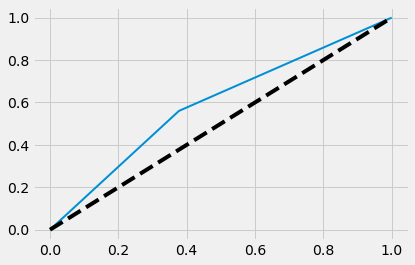

In [677]:
fpr,tpr, thresholds = roc_curve(y_test, max_depth_grid_search.predict(X_test))

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

print('Area under ROC Curve : %f'%roc_auc_score(y_test, max_depth_grid_search.predict(X_test)))
plot_roc_curve(fpr, tpr)
plt.show()

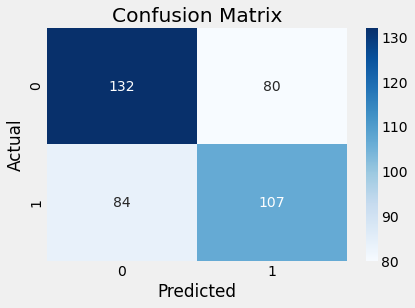

In [644]:
cm= confusion_matrix(y_test,max_depth_grid_search.predict(X_test))

temp = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

sns.heatmap(temp, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [645]:
print(classification_report(y_test,max_depth_grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       212
           1       0.57      0.56      0.57       191

    accuracy                           0.59       403
   macro avg       0.59      0.59      0.59       403
weighted avg       0.59      0.59      0.59       403



Text(0.5, 0, 'Variable Importance')

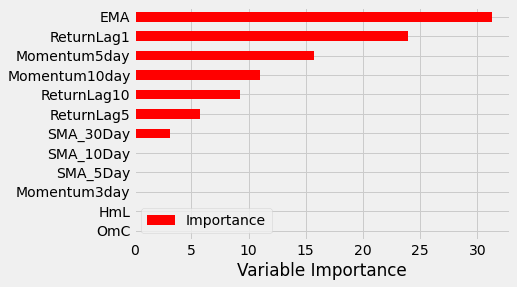

In [651]:
Importance = pd.DataFrame({'Importance':max_depth_grid_search.best_estimator_.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

### Decision Boundaries

The pruned tree model(Model 2) above is vast improvement to Model 1 in terms of f1 scores and accuracy. In order to demonstrate decision boundaries in 2D, I have selected best 2 features (EMA & ReturnLag1)  from the above and retrained the model. 

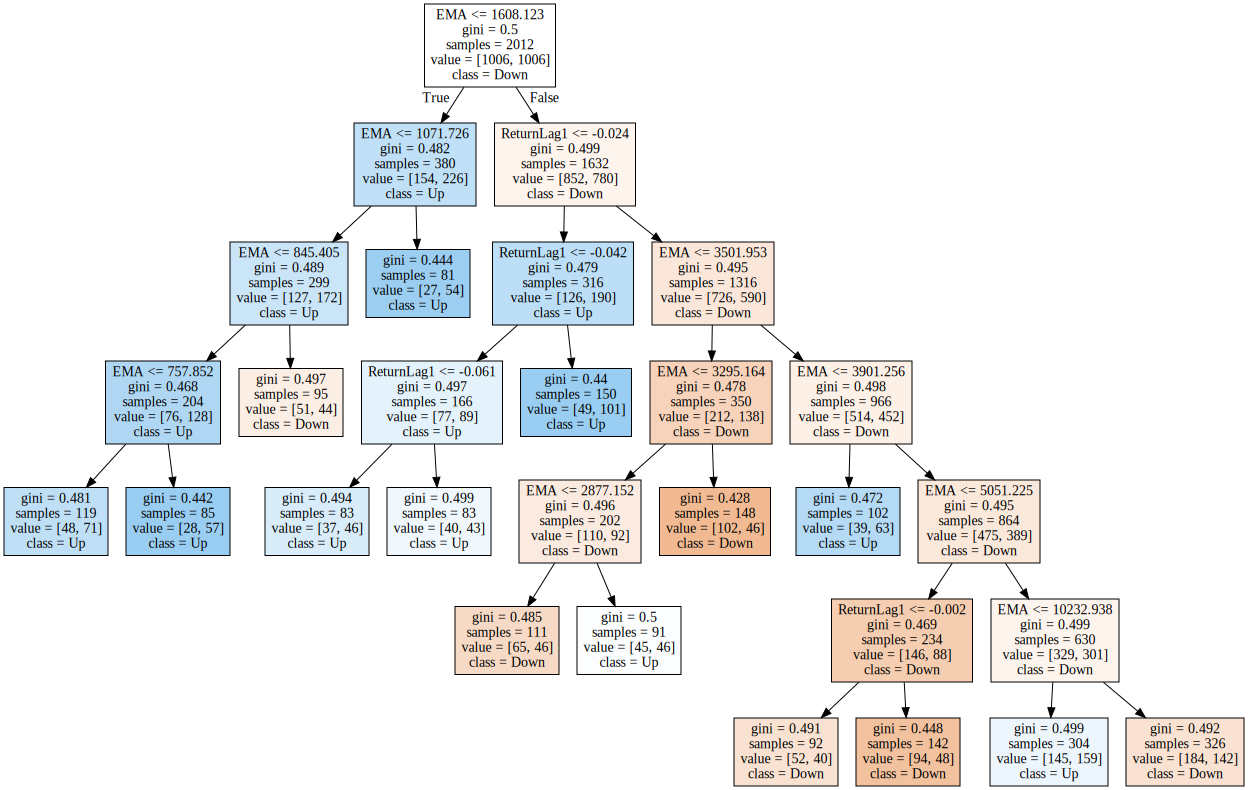

In [671]:

dt = DecisionTreeClassifier(random_state =42,max_depth =6, min_samples_leaf=80, min_samples_split= 2)
dt_mod = dt.fit(X[['ReturnLag1','EMA']],y['MoveDirection'])



dot_data = tree.export_graphviz(dt_mod, out_file=None, 
                                feature_names=list(X[['ReturnLag1','EMA']].columns),  
                                class_names=['Down','Up'],
                                filled=True)
graphviz.Source(dot_data, format="png") 

Text(0, 0.5, 'Exponential Moving Average')

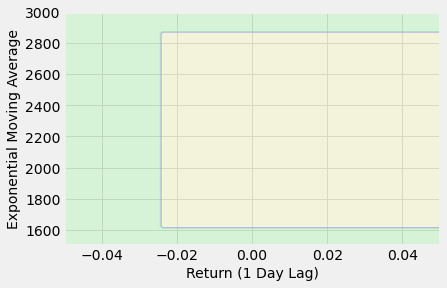

In [674]:

axes = [-0.05,0.05,1500,3000]
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)

X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred =dt_mod.predict(X_new).reshape(x1.shape)

custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

plt.xlabel("Return (1 Day Lag)", fontsize=14)
plt.ylabel("Exponential Moving Average", fontsize=14)


# Ensemble Learning

Based on the above results AdaBoost performs the best amongst all the alternative models considered.Boosting algorithms typically convert weak leaners to strong learners.The principal behind boosting is algorithms is first we built a model on the training set and then the second model is built to rectify the errors in the first model. The procedure is continued until and unless the errors are minimized and the dataset is predicted correctly.

The first one (Adaboost, for adaptive boosting) improves the learning process by progressively focusing on the instances that yield the largest errors. The second one (xgboost) is a flexible algorithm in which each new tree is only focused on the minimization of the training sample loss.

Empirical design of Adaboost is as follows:

1. When training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set.

1. The algorithm then increases the relative weight of misclassified training instances.(See figure below [3])

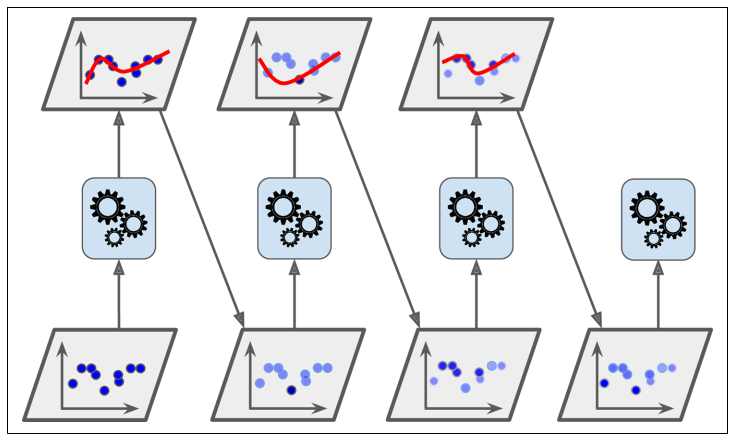
1. Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on theiroverall accuracy on the weighted training set.



In [681]:
Ada = AdaBoostClassifier(DecisionTreeClassifier(),
                          n_estimators=300, random_state=42)
Ada.fit(X_train, y_train['MoveDirection'].ravel())

print("Adaboost Model Accuracy: ",Ada.score(X_test,y_test))

Adaboost Model Accuracy:  0.5037220843672456


In [676]:
# Scale and fit the classifier model
xgbcls =  XGBClassifier(verbosity = 0, silent=True, random_state=42)
xgbcls.fit(np.array(X_train), y_train['MoveDirection'].ravel())

print("Untuned XGBoost Accuracy:",xgbcls.score(X_test,y_test))

Untuned XGBoost Accuracy: 0.5459057071960298


C:\Users\ASUS\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [679]:
# Grid Search: Ada boost Algorithm Tuning 
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated. 
    In case of perfect fit, the learning procedure is stopped early.
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [10, 50, 100, 500, 1000, 5000]
param_grid = dict(n_estimators=n_estimators)
model = AdaBoostClassifier()
num_folds =3
seed =42
kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=kfold)
grid_result = grid.fit(rescaledX, y_train['MoveDirection'].ravel())

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.561667 using {'n_estimators': 50}
#3 0.547117 (0.035809) with: {'n_estimators': 10}
#1 0.561667 (0.012065) with: {'n_estimators': 50}
#2 0.548651 (0.005580) with: {'n_estimators': 100}
#4 0.531837 (0.007511) with: {'n_estimators': 500}
#6 0.521878 (0.016560) with: {'n_estimators': 1000}
#5 0.531793 (0.026165) with: {'n_estimators': 5000}


In [680]:
# XGboost: Hyper parameter Tuning
param_grid = {'learning_rate': [0.05, 0.15, 0.25, 0.35],
              'max_depth': [3, 5, 8, 10, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]}

num_folds =3
seed =42
kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)

# perform random search
rs = GridSearchCV(xgbcls, param_grid, scoring='f1', cv=kfold, verbose=0)
rs.fit(np.array(X_train), y_train['MoveDirection'].ravel(), verbose=0)

#Print Results
print("Best: %f using %s" % (rs.best_score_, grid_result.best_params_))
means = rs.cv_results_['mean_test_score']
stds = rs.cv_results_['std_test_score']
params = rs.cv_results_['params']
ranks = rs.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

C:\Users\ASUS\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best: 0.550527 using {'n_estimators': 50}
#88 0.537046 (0.009107) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1}
#73 0.537583 (0.004122) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3}
#315 0.530299 (0.010149) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5}
#28 0.540217 (0.011506) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7}
#325 0.530006 (0.013703) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1}
#1335 0.513489 (0.025297) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3}
#1118 0.517846 (0.007886) with: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5}
#453 0.527961 (0.013160) wit

# Trading Strategy Backtest 

I have used trading signals generated from the AdaBoost model trained above to generate backtesting results. Predict_proba() method gives out probabilities of negative and positive daily returns which I have converted into Kelly Optimal bet size using the formula $ 2*p- 1$ and compared against 100% bets on the underlying asset.

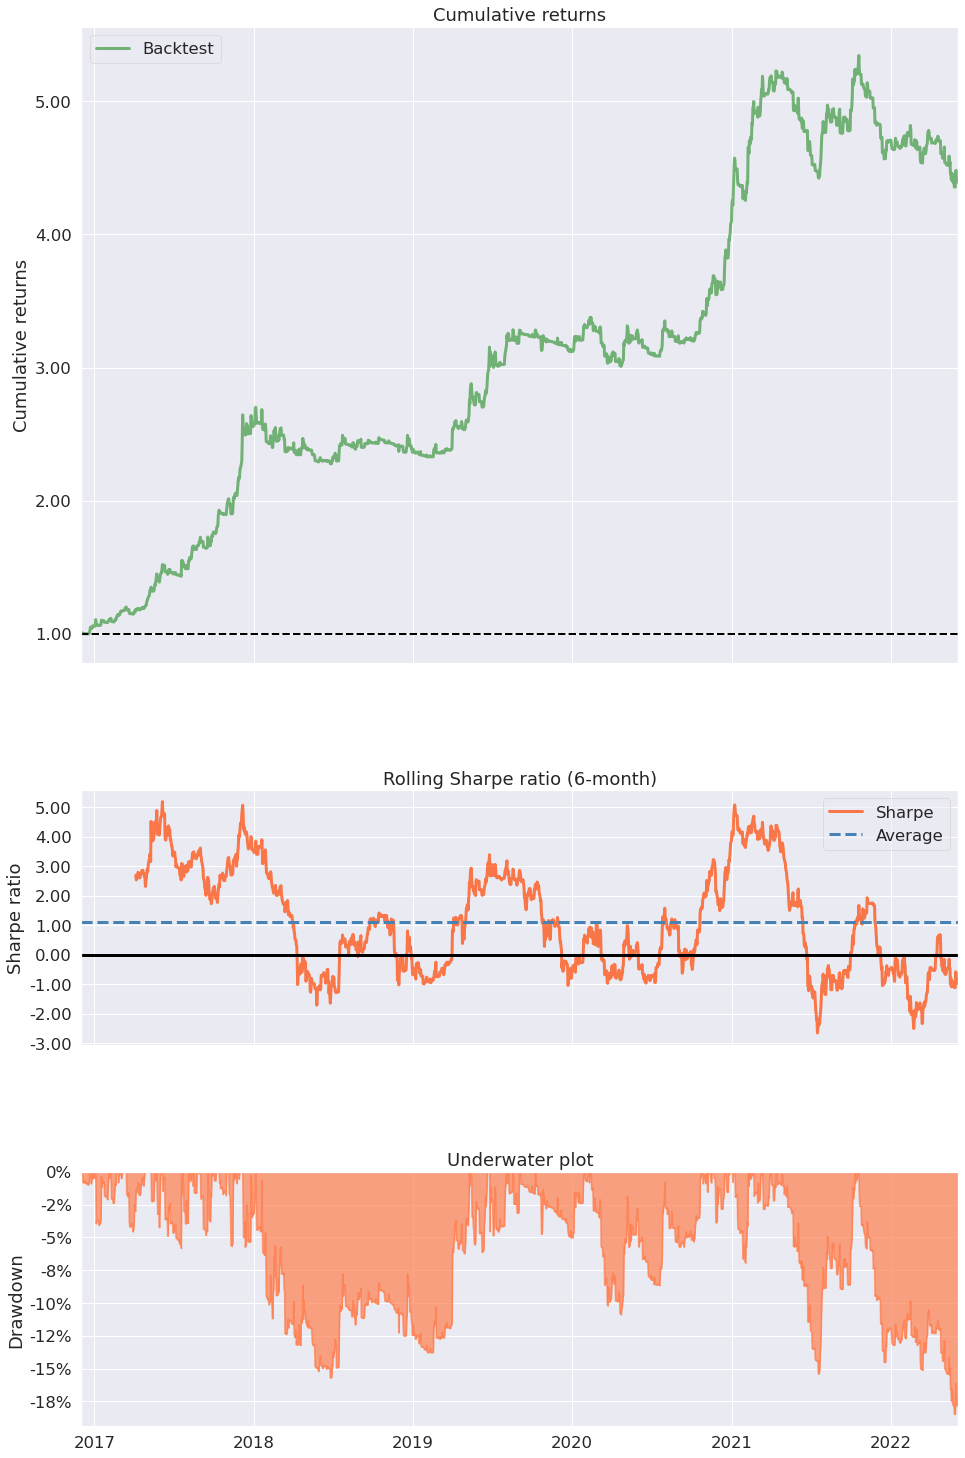

In [684]:
#Kelly Optimal Bets
p = 2 * grid_result .predict_proba(X)[:,1] -1
Features['Strategy'] =  Features.loc[:,'Returns'].mul(p, axis=0)
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(Features['Strategy'])

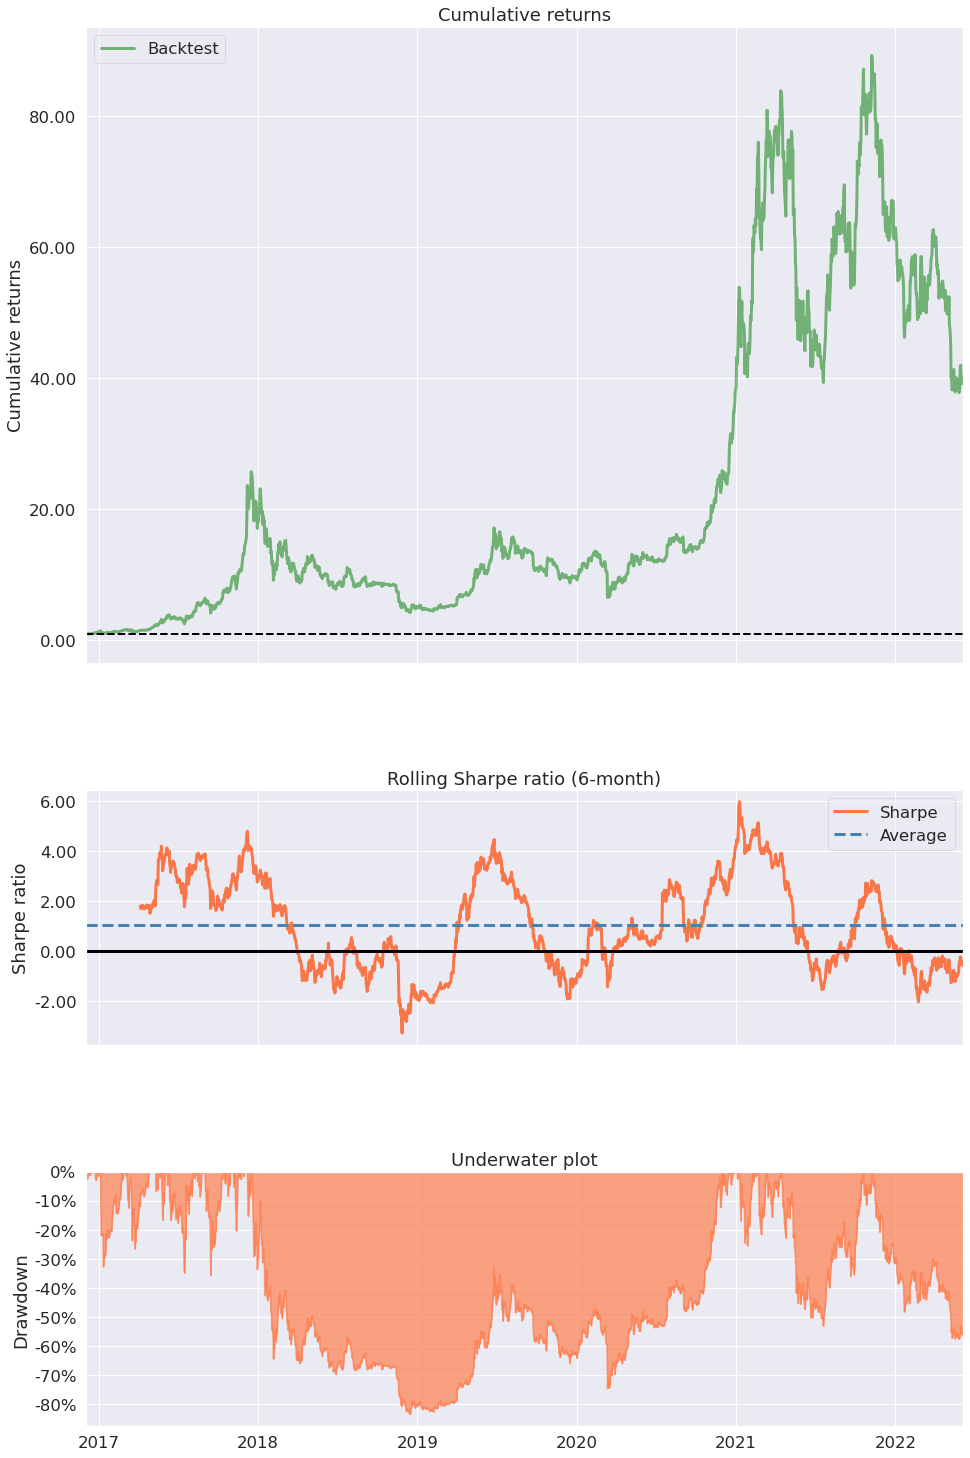

In [685]:
#100% Long Bet
p = 1
Features['Strategy'] =  Features.loc[:,'Returns'].mul(p, axis=0)
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(Features['Strategy'])

# References

1. https://towardsdatascience.com/build-better-decision-trees-with-pruning-8f467e73b107

2. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.

3. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow , Aurélien Géron

